In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_columns=200
path = '/content/drive/MyDrive/Colab Notebooks/Retail/data/'

In [ ]:
%%time
df = pd.read_parquet(path + "df_preprocessed_3.parquet")

CPU times: user 6.48 s, sys: 2.56 s, total: 9.04 s
Wall time: 11.1 s


In [ ]:
df['GDS_NM']= df['GDS_NM'].str.replace(pat=r'[^\w]',repl=r' ',regex=True)
df['GDS_NM']
df['GDS_NM'] = df['GDS_NM'].str.replace(" ", "")
df = df.astype({'SALE_QTY' : 'int'})
df = df.astype({'SALE_PRC' : 'int'})
df = df.astype({'SALE_AMT' : 'int'})

In [ ]:
cate_df = pd.read_parquet(path + "category_map2.parquet")

In [ ]:
cate_raw = pd.read_excel(path + "리테일_카테고리_분류.xlsx")
cate_raw = cate_raw[["대", "소"]].drop_duplicates()
cate_raw = cate_raw.assign(cate_id = range(len(cate_raw)))    

In [ ]:
cate_raw["소"] = cate_raw["소"].fillna("미분류")

In [ ]:
df = df.sample(frac=0.05)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1137580 entries, 17321185 to 20950330
Data columns (total 9 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   PLU_CD            1137580 non-null  int64         
 1   GDS_NM            1137580 non-null  object        
 2   SALE_QTY          1137580 non-null  float64       
 3   SALE_PRC          1137580 non-null  float64       
 4   SALE_AMT          1137580 non-null  float64       
 5   SCALES_GDS_TP_NM  1137580 non-null  object        
 6   mart_name         1137580 non-null  object        
 7   log_dt            1137580 non-null  datetime64[ns]
 8   cate_id           146510 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1), object(3)
memory usage: 86.8+ MB


In [ ]:
df

,PLU_CD,GDS_NM,SALE_QTY,SALE_PRC,SALE_AMT,SCALES_GDS_TP_NM,mart_name,log_dt,cate_id
5461215,8809568420631,설탕대신스테비아,1,5800,5800,일반,A마트,2021-07-25 20:36:56,NaN
684347,2909441429020,인큐애호박2개행사,1,1000,1000,일반,A마트,2021-04-16 15:39:33,NaN
16014632,23000735,봉지파프리카,1,1980,1980,일반,H마트,2022-07-01 11:37:30,101.0
17897586,23001336,단호박국산행사,1,2500,2500,일반,I마트,2021-08-31 07:46:46,NaN
19494935,8801118251221,롯데구구콘스타초코,1,1000,1000,일반,I마트,2022-08-03 21:38:43,NaN
...,...,...,...,...,...,...,...,...,...
3383636,8801056051921,롯데칸타타카라멜마키아토,2,990,1980,일반,A마트,2021-05-23 09:35:06,NaN
18100587,201145,자색감자,1,1000,1000,일반저울,I마트,2021-09-08 19:19:58,NaN
2263907,2908990007611,완두콩1망2kg,1,7980,7980,일반,A마트,2021-05-25 14:44:44,NaN
12877099,201351,모듬쌈채,1,5370,5370,일반저울,F마트,2021-09-11 18:44:05,NaN


In [ ]:
test = df['PLU_CD'].value_counts()
test

2908990008649    12030
2908990006331     5278
22001375          5014
290000000018      4744
8801115114154     4128
                 ...  
8809057684223        1
218044               1
8809040193466        1
8809194583557        1
8801046328439        1
Name: PLU_CD, Length: 32606, dtype: int64

In [ ]:
test.head(50)

In [ ]:
print(df.cate_id.isna().sum()/len(df.cate_id)*100)

86.1773237926124


In [ ]:
## 현재 확인
print(f"카테고리 커버리지: {df.cate_id.notna().mean()*100:.2f}%")

sale_coverage = df.loc[df.cate_id.notna(), "SALE_AMT"].sum() / df.SALE_AMT.sum()
print(f"매출액 커버리지: {sale_coverage*100:.2f}%")

sale_qty_coverage = df.loc[df.cate_id.notna(), "SALE_QTY"].sum() / df.SALE_QTY.sum()
print(f"판매량 커버리지: {sale_qty_coverage*100:.2f}%")

카테고리 커버리지: 13.82%
매출액 커버리지: 16.41%
판매량 커버리지: 12.34%


### 기본 전처리

In [ ]:
df = df.assign(
    month = df.log_dt.dt.month,
    weekday = df.log_dt.dt.weekday,
    hour = df.log_dt.dt.hour
)

### 정답지

In [ ]:
df_answer = df[df.cate_id.notna()]

In [ ]:
assert df_answer.groupby("GDS_NM").cate_id.nunique().max() == 1

In [ ]:
df.groupby(["mart_name", "GDS_NM"]).SALE_AMT.sum()

mart_name  GDS_NM     
A마트          메가촉 초코         2160.0
            M2마스크대형백        2800.0
            고급산적꽃이(소)       4600.0
            냉동혼합야채(4종)      4100.0
            단지 깐메추리알       25760.0
                            ...   
P마트        휴대용물병            4000.0
           흑토마토             9800.0
           흙마늘훈제오리        360000.0
           흙생강             50360.0
           힐링덕오리훈제         54000.0
Name: SALE_AMT, Length: 84572, dtype: float64

### 정답에서 정답 만들기

In [ ]:
def candidate_generation(cate_raw, gds_nm):

    raw_name_cover = cate_raw[cate_raw["소"].str.contains(gds_nm)]
    target_name_cover = cate_raw[cate_raw["소"].apply(lambda x: x in gds_nm)]
    
    cand_df = pd.concat([raw_name_cover, target_name_cover]).drop_duplicates()
    return cand_df 

In [ ]:
def simple_jaccard_sim(word1, word2):
    s1 = set(word1)
    
    s2 = set(word2)
    return len(s1 & s2) / len(s1 | s2)

In [ ]:
def _feature_generator(df, unique_hours):
    feature_dict = {}

    is_imported = (df.PLU_CD.astype(str).str[0] == '9').mean()
    is_factory = (df.PLU_CD.astype(str).str[3] == '880').mean()
    is_fresh = (df.PLU_CD.astype(str).str[0] == '2').mean()


    feature_dict["is_imported"] = is_imported
    feature_dict["is_factory"] = is_factory
    feature_dict["is_fresh"] = is_fresh


    
    hour_count = df.hour.value_counts(normalize=True)
    for hour_missed in set(unique_hours) - set(hour_count.index):
        hour_count.loc[hour_missed] = 0
    
    hour_count.index = [f"hourly_sale_ratio_{i}" for i in hour_count.index]
    feature_dict.update(hour_count.to_dict())

    feature_dict["sale_prc_mean"] = df.SALE_PRC.mean()
    feature_dict["sale_prc_median"] = df.SALE_PRC.median()
    
    return feature_dict

In [ ]:
def cand_info_generator(cand_df, mart_name, gds_nm, group):
    cand_dict = {}
    for _, row in cand_df.iterrows():
        cand_dict[row.cate_id] = {
            "tran": df[
                        (df.cate_id == row.cate_id) &
                        (df.mart_name != mart_name)
                    ],
            "name_sim":simple_jaccard_sim(row["소"], gds_nm),
            "label":group.cate_id.values[0] == row["cate_id"]
        }
    return cand_dict

def feature_generator(group, cand_dict):
    res = []
    group_feature = _feature_generator(group, unique_hours)
    group_feature = pd.Series(group_feature).to_frame().T
    group_feature.index = ["group"]
    group_feature = group_feature.rename(columns={col:f"{col}_group" for col in group_feature})

    for cand_id, cand_info in cand_dict.items():
        cand_df = cand_info["tran"]
        cand_feature = pd.Series(_feature_generator(cand_df, unique_hours)).to_frame().T
        cand_feature.index = [cand_id]

        cand_feature = cand_feature.rename(columns={col:f"{col}_cand" for col in group_feature})

        feature_row = pd.concat([group_feature.reset_index(drop=True), cand_feature.reset_index(drop=True)], axis=1)

        feature_row = feature_row.assign(
            name_sim = cand_info["name_sim"], 
            label = cand_info["label"]
        )

        res.append(feature_row)
        
    feature_df = pd.concat(res)
    return feature_df


In [ ]:
unique_hours = sorted(df.log_dt.dt.hour.unique())

group_sale = df_answer.groupby(["mart_name", "GDS_NM"]).SALE_AMT.sum()
group_sale = group_sale.sort_values(ascending=False)

In [ ]:
df_dict = {(mart_name, gds_nm):group for (mart_name, gds_nm), group in df.groupby(["mart_name", "GDS_NM"])}

In [ ]:
def _execute(mart_name, gds_nm, group):
    
#     group = df[
#         (df.mart_name == mart_name) &
#         (df.GDS_NM == gds_nm)
#     ]

    cate_id = group.cate_id.values[0]
    cand_df = candidate_generation(cate_raw, gds_nm)
    if len(cand_df) == 0:
        return
    
    cand_dict = cand_info_generator(cand_df, mart_name, gds_nm, group)
    feature_df_temp = feature_generator(group, cand_dict)
    
    return feature_df_temp


In [ ]:
res = Parallel(n_jobs=-1)(
    delayed(_execute)(mart_name, gds_nm, df_dict[(mart_name, gds_nm)]) 
    for (mart_name, gds_nm), sale_amt 
    in tqdm(group_sale.iteritems(), total=len(group_sale))
)

100%|██████████| 2913/2913 [12:51<00:00,  3.77it/s]


# 3538

In [ ]:
feature_df = pd.concat(res)

In [ ]:
feature_df.label.value_counts()

True     1682
False    1669
Name: label, dtype: int64

In [ ]:
res

### Postprocess

In [ ]:
hour_cols = [col for col in feature_df.columns if "hourly" in col]
sale_cols = [col for col in feature_df.columns if "sale_prc" in col]
bool_cols = [col for col in feature_df.columns if "is_" in col]

In [ ]:
assert set(feature_df.columns) == set(hour_cols + sale_cols + bool_cols + ["label", "name_sim"])

In [ ]:
hour_cols = sorted(hour_cols)
sale_cols = sorted(sale_cols)

In [ ]:
feature_df = feature_df[hour_cols + sale_cols + bool_cols + ["name_sim", "label"]]

In [ ]:
feature_df

,hourly_sale_ratio_1,hourly_sale_ratio_10,hourly_sale_ratio_10_group,hourly_sale_ratio_11,hourly_sale_ratio_11_group,hourly_sale_ratio_12,hourly_sale_ratio_12_group,hourly_sale_ratio_13,hourly_sale_ratio_13_group,hourly_sale_ratio_14,hourly_sale_ratio_14_group,hourly_sale_ratio_15,hourly_sale_ratio_15_group,hourly_sale_ratio_16,hourly_sale_ratio_16_group,hourly_sale_ratio_17,hourly_sale_ratio_17_group,hourly_sale_ratio_18,hourly_sale_ratio_18_group,hourly_sale_ratio_19,hourly_sale_ratio_19_group,hourly_sale_ratio_1_group,hourly_sale_ratio_2,hourly_sale_ratio_20,hourly_sale_ratio_20_group,hourly_sale_ratio_21,hourly_sale_ratio_21_group,hourly_sale_ratio_22,hourly_sale_ratio_22_group,hourly_sale_ratio_23,hourly_sale_ratio_23_group,hourly_sale_ratio_2_group,hourly_sale_ratio_3,hourly_sale_ratio_3_group,hourly_sale_ratio_4,hourly_sale_ratio_4_group,hourly_sale_ratio_5,hourly_sale_ratio_5_group,hourly_sale_ratio_6,hourly_sale_ratio_6_group,hourly_sale_ratio_7,hourly_sale_ratio_7_group,hourly_sale_ratio_8,hourly_sale_ratio_8_group,hourly_sale_ratio_9,hourly_sale_ratio_9_group,sale_prc_mean,sale_prc_mean_group,sale_prc_median,sale_prc_median_group,is_imported_group,is_factory_group,is_fresh_group,is_imported,is_factory,is_fresh,name_sim,label
0,0.0,0.034884,0.061523,0.046512,0.068359,0.040698,0.083984,0.069767,0.097656,0.063953,0.110352,0.093023,0.103516,0.087209,0.107422,0.127907,0.118164,0.145349,0.097656,0.133721,0.068359,0.0,0.0,0.063953,0.040039,0.040698,0.009766,0.017442,0.000000,0.005814,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002930,0.011628,0.008789,0.017442,0.021484,20771.860465,13735.351562,16735.0,12840.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.285714,False
0,0.0,0.038992,0.045367,0.051201,0.064672,0.049232,0.083012,0.057109,0.083012,0.064199,0.083012,0.076408,0.108108,0.117369,0.126448,0.153210,0.148649,0.146514,0.104247,0.096889,0.058880,0.0,0.0,0.046081,0.042471,0.042536,0.017375,0.018905,0.000000,0.009453,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000394,0.004826,0.004726,0.008687,0.026782,0.021236,16166.549823,13463.204633,14490.0,12970.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.428571,True
0,0.0,0.041704,0.048626,0.059641,0.076110,0.069955,0.046512,0.065247,0.061311,0.080493,0.073996,0.093049,0.084567,0.118834,0.118393,0.143498,0.169133,0.130942,0.133192,0.078700,0.103594,0.0,0.0,0.043274,0.033827,0.029372,0.025370,0.010538,0.002114,0.005381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001570,0.000000,0.004484,0.006342,0.023318,0.016913,14331.726457,19629.852008,13505.0,17320.0,0.0,0.0,1.0,0.0,0.0,0.426906,0.333333,True
0,0.0,0.147059,0.037471,0.058824,0.060890,0.058824,0.079625,0.029412,0.046838,0.088235,0.074941,0.088235,0.091335,0.147059,0.119438,0.117647,0.149883,0.058824,0.128806,0.058824,0.086651,0.0,0.0,0.058824,0.067916,0.088235,0.018735,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002342,0.000000,0.002342,0.000000,0.032787,26900.588235,18930.421546,17465.0,19100.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.285714,False
0,0.0,0.043757,0.038627,0.065635,0.027897,0.069613,0.062232,0.068508,0.042918,0.083315,0.055794,0.091934,0.079399,0.122210,0.103004,0.138785,0.199571,0.123536,0.188841,0.076685,0.103004,0.0,0.0,0.042873,0.036481,0.027845,0.038627,0.009724,0.006438,0.005304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001547,0.000000,0.005083,0.000000,0.023646,0.017167,14822.530387,15308.154506,13720.0,14780.0,0.0,0.0,1.0,0.0,0.0,0.435138,0.375000,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.

In [ ]:
feature_df_100['label'].value_counts()

True     1814
False    1323
Name: label, dtype: int64

# 최종

In [ ]:
feature_df = pd.read_parquet(path+'feature_df_2.parquet')


In [ ]:
feature_to_inference = pd.read_parquet(path+'feature_to_inference.parquet')

In [ ]:
feature_to_inference

,hourly_sale_ratio_0,hourly_sale_ratio_0_group,hourly_sale_ratio_1,hourly_sale_ratio_10,hourly_sale_ratio_10_group,hourly_sale_ratio_11,hourly_sale_ratio_11_group,hourly_sale_ratio_12,hourly_sale_ratio_12_group,hourly_sale_ratio_13,hourly_sale_ratio_13_group,hourly_sale_ratio_14,hourly_sale_ratio_14_group,hourly_sale_ratio_15,hourly_sale_ratio_15_group,hourly_sale_ratio_16,hourly_sale_ratio_16_group,hourly_sale_ratio_17,hourly_sale_ratio_17_group,hourly_sale_ratio_18,hourly_sale_ratio_18_group,hourly_sale_ratio_19,hourly_sale_ratio_19_group,hourly_sale_ratio_1_group,hourly_sale_ratio_2,hourly_sale_ratio_20,hourly_sale_ratio_20_group,hourly_sale_ratio_21,hourly_sale_ratio_21_group,hourly_sale_ratio_22,hourly_sale_ratio_22_group,hourly_sale_ratio_23,hourly_sale_ratio_23_group,hourly_sale_ratio_2_group,hourly_sale_ratio_3,hourly_sale_ratio_3_group,hourly_sale_ratio_4,hourly_sale_ratio_4_group,hourly_sale_ratio_5,hourly_sale_ratio_5_group,hourly_sale_ratio_6,hourly_sale_ratio_6_group,hourly_sale_ratio_7,hourly_sale_ratio_7_group,hourly_sale_ratio_8,hourly_sale_ratio_8_group,hourly_sale_ratio_9,hourly_sale_ratio_9_group,sale_prc_mean,sale_prc_mean_group,sale_prc_median,sale_prc_median_group,is_imported_group,is_factory_group,is_fresh_group,is_imported,is_factory,is_fresh,name_sim,label
0,0.0,0.0,0.000000,0.042524,0.066962,0.051603,0.088614,0.052638,0.086912,0.053097,0.089381,0.055281,0.100184,0.078497,0.116434,0.111367,0.119986,0.142397,0.105086,0.164809,0.085349,0.097690,0.053588,0.0,0.000115,0.057580,0.036940,0.035973,0.012680,0.019883,0.000000,0.004597,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000009,0.000690,0.000481,0.000690,0.002849,0.004137,0.008925,0.026434,0.025619,3543.599586,1935.926508,1500.0,1500.0,0.0,0.0,1.0,0.0,0.0,1.0,0.250000,False
0,0.0,0.0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.285714,False
0,0.0,0.0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.500000,False
0,0.0,0.0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.500000,False
0,0.0,0.0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.500000,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.000082,0.068770,0.000000,0.090250,0.000000,0.084415,0.000000,0.081949,0.00000

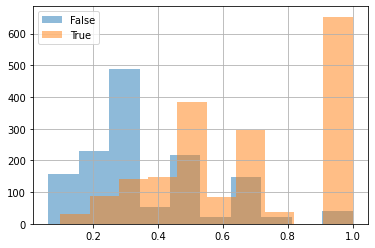

In [ ]:
## 라벨에 따른 이름 유사도 분포
leg = []
for label, group in feature_df.groupby("label"):
    group.name_sim.hist(alpha=0.5)
    leg.append(label)
plt.legend(leg)
plt.show()

In [ ]:
# feature_df = feature_df.fillna(0)
# feature_df

In [ ]:
# feature_df_100 = pd.read_parquet(path+'feature_df.parquet')

In [ ]:
feature_df.shape

(3239, 60)

In [ ]:
feature_df['label'].value_counts()

True     1866
False    1373
Name: label, dtype: int64

In [ ]:
feature_df.columns

Index(['hourly_sale_ratio_1', 'hourly_sale_ratio_10',
       'hourly_sale_ratio_10_group', 'hourly_sale_ratio_11',
       'hourly_sale_ratio_11_group', 'hourly_sale_ratio_12',
       'hourly_sale_ratio_12_group', 'hourly_sale_ratio_13',
       'hourly_sale_ratio_13_group', 'hourly_sale_ratio_14',
       'hourly_sale_ratio_14_group', 'hourly_sale_ratio_15',
       'hourly_sale_ratio_15_group', 'hourly_sale_ratio_16',
       'hourly_sale_ratio_16_group', 'hourly_sale_ratio_17',
       'hourly_sale_ratio_17_group', 'hourly_sale_ratio_18',
       'hourly_sale_ratio_18_group', 'hourly_sale_ratio_19',
       'hourly_sale_ratio_19_group', 'hourly_sale_ratio_1_group',
       'hourly_sale_ratio_2', 'hourly_sale_ratio_20',
       'hourly_sale_ratio_20_group', 'hourly_sale_ratio_21',
       'hourly_sale_ratio_21_group', 'hourly_sale_ratio_22',
       'hourly_sale_ratio_22_group', 'hourly_sale_ratio_23',
       'hourly_sale_ratio_23_group', 'hourly_sale_ratio_2_group',
       'hourly_sale_ratio_3'

In [ ]:
x = feature_df[
    hour_cols + 
    sale_cols + 
    bool_cols + 
    ["name_sim"]
]
y = feature_df[['label']]

In [ ]:
feature_df

,hourly_sale_ratio_0,hourly_sale_ratio_0_group,hourly_sale_ratio_1,hourly_sale_ratio_10,hourly_sale_ratio_10_group,hourly_sale_ratio_11,hourly_sale_ratio_11_group,hourly_sale_ratio_12,hourly_sale_ratio_12_group,hourly_sale_ratio_13,hourly_sale_ratio_13_group,hourly_sale_ratio_14,hourly_sale_ratio_14_group,hourly_sale_ratio_15,hourly_sale_ratio_15_group,hourly_sale_ratio_16,hourly_sale_ratio_16_group,hourly_sale_ratio_17,hourly_sale_ratio_17_group,hourly_sale_ratio_18,hourly_sale_ratio_18_group,hourly_sale_ratio_19,hourly_sale_ratio_19_group,hourly_sale_ratio_1_group,hourly_sale_ratio_2,hourly_sale_ratio_20,hourly_sale_ratio_20_group,hourly_sale_ratio_21,hourly_sale_ratio_21_group,hourly_sale_ratio_22,hourly_sale_ratio_22_group,hourly_sale_ratio_23,hourly_sale_ratio_23_group,hourly_sale_ratio_2_group,hourly_sale_ratio_3,hourly_sale_ratio_3_group,hourly_sale_ratio_4,hourly_sale_ratio_4_group,hourly_sale_ratio_5,hourly_sale_ratio_5_group,hourly_sale_ratio_6,hourly_sale_ratio_6_group,hourly_sale_ratio_7,hourly_sale_ratio_7_group,hourly_sale_ratio_8,hourly_sale_ratio_8_group,hourly_sale_ratio_9,hourly_sale_ratio_9_group,sale_prc_mean,sale_prc_mean_group,sale_prc_median,sale_prc_median_group,is_imported_group,is_factory_group,is_fresh_group,is_imported,is_factory,is_fresh,name_sim,label
0,0.0,0.0,0.000297,0.058111,0.061190,0.071578,0.088120,0.068669,0.085613,0.064869,0.084099,0.073026,0.098242,0.094637,0.118029,0.109106,0.122491,0.118302,0.107970,0.110888,0.091588,0.075972,0.058368,0.0,0.000483,0.050277,0.039354,0.037602,0.013496,0.013702,0.000000,0.002117,0.0,0.0,0.000309,0.0,0.000297,0.0,0.000408,0.0,0.000582,0.000378,0.001399,0.002680,0.009790,0.006906,0.037578,0.021474,2614.156672,2655.636421,2300.0,2500.0,0.0,0.0,1.0,0.0,0.0,1.0,0.400000,True
0,0.0,0.0,0.000076,0.041465,0.036397,0.051673,0.056549,0.054596,0.055624,0.048326,0.059120,0.060820,0.066934,0.082704,0.092124,0.116960,0.132737,0.149218,0.158955,0.151747,0.154329,0.089428,0.092021,0.0,0.000061,0.051536,0.042361,0.040890,0.030125,0.021702,0.000411,0.008072,0.0,0.0,0.000015,0.0,0.000045,0.0,0.000106,0.0,0.000197,0.000000,0.000575,0.000000,0.004452,0.002262,0.025337,0.020049,15724.927080,18875.512030,14230.0,17140.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333,True
0,0.0,0.0,0.000505,0.055220,0.055687,0.069054,0.087595,0.065294,0.088444,0.062151,0.090143,0.079435,0.104337,0.095513,0.117076,0.108673,0.121444,0.116922,0.099424,0.105671,0.087837,0.080530,0.055020,0.0,0.000393,0.062909,0.044465,0.042762,0.018987,0.011308,0.000000,0.002385,0.0,0.0,0.000224,0.0,0.000168,0.0,0.000196,0.0,0.000673,0.000243,0.001880,0.002548,0.006874,0.009099,0.031258,0.017652,9097.437077,9629.814983,9800.0,9800.0,0.0,0.0,1.0,0.0,0.0,1.0,0.333333,True
0,0.0,0.0,0.000226,0.055997,0.051064,0.067215,0.070035,0.066683,0.077465,0.065069,0.082614,0.074883,0.092122,0.096981,0.111026,0.117337,0.122589,0.126731,0.120150,0.114931,0.105651,0.075529,0.068318,0.0,0.000323,0.046279,0.044966,0.032672,0.015674,0.011461,0.000000,0.001727,0.0,0.0,0.000178,0.0,0.000016,0.0,0.000161,0.0,0.000436,0.000271,0.001227,0.002417,0.007070,0.008085,0.036868,0.027553,3172.203067,3290.540449,2720.0,2730.0,0.0,0.0,1.0,0.0,0.0,1.0,1.000000,True
0,0.0,0.0,0.000000,0.000000,0.051064,0.000000,0.070035,0.000000,0.077465,0.000000,0.082614,0.000000,0.092122,0.000000,0.111026,0.000000,0.122589,0.000000,0.120150,0.000000,0.105651,0.000000,0.068318,0.0,0.000000,0.000000,0.044966,0.000000,0.015674,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000271,0.000000,0.002417,0.000000,0.008085,0.000000,0.027553,0.000000,3290.540449,0.0,2730.0,0.0,0.0,1.0,0.0,0.0,0.0,0.333333,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.000084,0.055822,0.000000,0.076400,0.000000,0.077925,0.000000,0.077937,0.500000,0.089020,0.000

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size = 0.3, random_state=0
)

In [ ]:
!pip install Bayesian-Optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_validate
import lightgbm as lgb
from bayes_opt import BayesianOptimization

def lgbm_cv(learning_rate, num_leaves, max_depth, min_child_weight, colsample_bytree, feature_fraction, bagging_fraction, lambda_l1, lambda_l2):
    model = lgb.LGBMClassifier(learning_rate=learning_rate,
                                n_estimators = 1000,
                                #boosting = 'dart',
                                num_leaves = int(round(num_leaves)),
                                max_depth = int(round(max_depth)),
                                min_child_weight = int(round(min_child_weight)),
                                colsample_bytree = colsample_bytree,
                                feature_fraction = max(min(feature_fraction, 1), 0),
                                bagging_fraction = max(min(bagging_fraction, 1), 0),
                                lambda_l1 = max(lambda_l1, 0),
                                lambda_l2 = max(lambda_l2, 0)
                               )
    scoring = {'roc_auc_score': make_scorer(roc_auc_score)}
    result = cross_validate(model, x_train, y_train, cv=5, scoring=scoring)
    auc_score = result["test_roc_auc_score"].mean()
    return auc_score

In [ ]:
pbounds = {'learning_rate' : (0.001, 0.03),
           'num_leaves': (300, 600),
           'max_depth': (2, 25),
           'min_child_weight': (30, 100),
           'colsample_bytree': (0, 0.99),
           'feature_fraction': (0.001, 0.99),
           'bagging_fraction': (0.001, 0.99),
           'lambda_l1' : (0, 0.99),
           'lambda_l2' : (0, 0.99)
          }

In [ ]:
#f: 목적함수, pbounds:입력값의 탐색구간
lgbmBO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 42 )
#목적함수가 최대가 되는 최적해 찾기(acq=ei)
lgbmBO.maximize(init_points=5, n_iter = 20, acq='ei', xi=0.01)

|   iter    |  target   | baggin... | colsam... | featur... | lambda_l1 | lambda_l2 | learni... | max_depth | min_ch... | num_le... |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.857    |  0.3714   |  0.9412   |  0.7249   |  0.5927   |  0.1545   |  0.005524 |  3.336    |  90.63    |  480.3    |
|  2        |  0.8664   |  0.7013   |  0.02038  |  0.9602   |  0.8241   |  0.2102   |  0.006273 |  6.218    |  51.3     |  457.4    |
|  3        |  0.8578   |  0.4282   |  0.2883   |  0.6061   |  0.1381   |  0.2892   |  0.01162  |  12.49    |  84.96    |  359.9    |
|  4        |  0.8255   |  0.5096   |  0.5865   |  0.04694  |  0.6015   |  0.1688   |  0.002886 |  23.82    |  97.59    |  542.5    |
|  5        |  0.8581   |  0.3023   |  0.0967   |  0.6777   |  0.4358   |  0.1208   |  0.01536  |  2.791    |  93.65    |  377.6    |
|  6        |  0.869    |  0.7197   |  0.9349   |  0.605    | 

In [ ]:
lgbmBO.max

{'target': 0.887216841856017,
 'params': {'bagging_fraction': 0.6646770743328058,
  'colsample_bytree': 0.926366650874676,
  'feature_fraction': 0.931288448243059,
  'lambda_l1': 0.26696833330686326,
  'lambda_l2': 0.9270942999640044,
  'learning_rate': 0.028139273049861246,
  'max_depth': 23.299883805253447,
  'min_child_weight': 30.441973561497228,
  'num_leaves': 551.5577630415677}}

In [ ]:
fit_lgbm = lgb.LGBMClassifier(learning_rate=lgbmBO.max['params']['learning_rate'],
                               num_leaves = int(round(lgbmBO.max['params']['num_leaves'])),
                               max_depth = int(round(lgbmBO.max['params']['max_depth'])),
                               min_child_weight = int(round(lgbmBO.max['params']['min_child_weight'])),
                               colsample_bytree=lgbmBO.max['params']['colsample_bytree'],
                               feature_fraction = max(min(lgbmBO.max['params']['feature_fraction'], 1), 0),
                               bagging_fraction = max(min(lgbmBO.max['params']['bagging_fraction'], 1), 0),
                               lambda_l1 = lgbmBO.max['params']['lambda_l1'],
                               lambda_l2 = lgbmBO.max['params']['lambda_l2']
                               )

In [ ]:
# lgb = lgb.LGBMClassifier()

In [ ]:
# clf = lgb.fit(x_train,y_train)

In [ ]:
# y_pred = clf.predict(x_test)

In [ ]:
model = fit_lgbm.fit(x_train,y_train)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model accuracy score: 0.8848


In [ ]:
print('Training set score : {:.4f}'.format(model.score(x_train, y_train)))
print('Test set score : {:.4f}'.format(model.score(x_test, y_test)))

Training set score : 0.9065
Test set score : 0.8848


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print('Confusion Matrix\n\n', cm)
print(f'True Positive(TP) = {cm[0][0]}')
print(f'True Negative(TN) = {cm[1][1]}')
print(f'False Positive(FP) = {cm[0][1]}')
print(f'False Negative(FN) = {cm[1][0]}')

Confusion Matrix

 [[329  72]
 [ 40 531]]
True Positive(TP) = 329
True Negative(TN) = 531
False Positive(FP) = 72
False Negative(FN) = 40


In [ ]:
import seaborn as sns

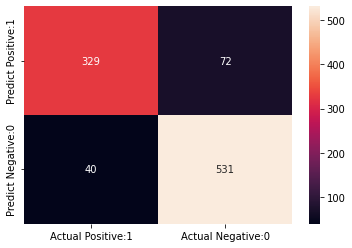

In [ ]:
cm_matrix = pd.DataFrame(data=cm,
                        columns=['Actual Positive:1', 'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix, annot=True, fmt='d')

In [ ]:
print('accuracy_score:',accuracy_score(y_test, y_pred))
print('precision_score:',precision_score(y_test, y_pred))
print('recall_score:',recall_score(y_test, y_pred))

accuracy_score: 0.8847736625514403
precision_score: 0.8805970149253731
recall_score: 0.9299474605954466


In [ ]:
# x_test = x_test.assign(label = y_test, pred=y_pred)
# x_test.groupby(["label", "pred"]).size()
# cm_fp  = x_test[(x_test.label == False)&(x_test.pred == True)]
# cm_fp

## threshold

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import Binarizer

pred_proba = model.predict_proba(x_test)
pred = model.predict(x_test)

pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print(pred_proba_result[:3])

[[0.05065258 0.94934742 1.        ]
 [0.91647415 0.08352585 0.        ]
 [0.90293118 0.09706882 0.        ]]


In [ ]:
from sklearn.preprocessing import Binarizer
 
custom_threshold = 0.87

# Positive 컬럼에 Binarizer 적용
pred_proba_1 = pred_proba[:,1].reshape(-1,1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1) 
custom_predict = binarizer.transform(pred_proba_1)


# 오차행렬
print(confusion_matrix(y_test, custom_predict))
print('accuracy_score:',accuracy_score(y_test, custom_predict))
print('precision_score:',precision_score(y_test, custom_predict))
print('recall_score:',recall_score(y_test, custom_predict))

[[398   3]
 [231 340]]
accuracy_score: 0.7592592592592593
precision_score: 0.9912536443148688
recall_score: 0.5954465849387041


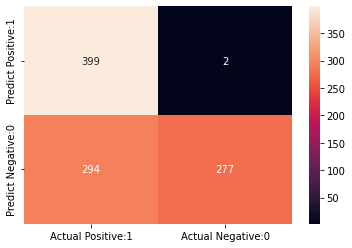

In [ ]:
cm_2 = confusion_matrix(y_test, custom_predict)

cm_matrix_thres = pd.DataFrame(data=cm_2,
                        columns=['Actual Positive:1', 'Actual Negative:0'],
                        index=['Predict Positive:1', 'Predict Negative:0'])
sns.heatmap(cm_matrix_thres, annot=True, fmt='d')

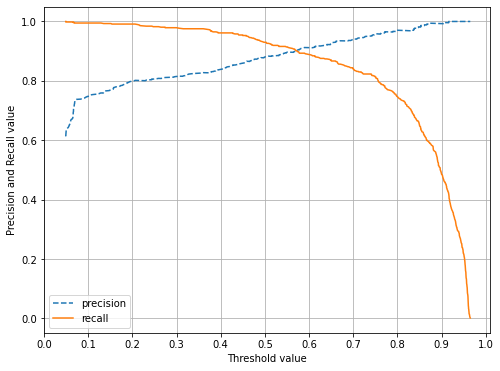

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # 그래프 설정: x scale, x/y label, legend, grid
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()



precision_recall_curve_plot(y_test, model.predict_proba(x_test)[:, 1])

# 적용

In [ ]:
feature_to_inference = feature_to_inference.drop(['label'], axis=1)

In [ ]:
feature_to_inference

,hourly_sale_ratio_1,hourly_sale_ratio_10,hourly_sale_ratio_10_group,hourly_sale_ratio_11,hourly_sale_ratio_11_group,hourly_sale_ratio_12,hourly_sale_ratio_12_group,hourly_sale_ratio_13,hourly_sale_ratio_13_group,hourly_sale_ratio_14,hourly_sale_ratio_14_group,hourly_sale_ratio_15,hourly_sale_ratio_15_group,hourly_sale_ratio_16,hourly_sale_ratio_16_group,hourly_sale_ratio_17,hourly_sale_ratio_17_group,hourly_sale_ratio_18,hourly_sale_ratio_18_group,hourly_sale_ratio_19,hourly_sale_ratio_19_group,hourly_sale_ratio_1_group,hourly_sale_ratio_2,hourly_sale_ratio_20,hourly_sale_ratio_20_group,hourly_sale_ratio_21,hourly_sale_ratio_21_group,hourly_sale_ratio_22,hourly_sale_ratio_22_group,hourly_sale_ratio_23,hourly_sale_ratio_23_group,hourly_sale_ratio_2_group,hourly_sale_ratio_3,hourly_sale_ratio_3_group,hourly_sale_ratio_4,hourly_sale_ratio_4_group,hourly_sale_ratio_5,hourly_sale_ratio_5_group,hourly_sale_ratio_6,hourly_sale_ratio_6_group,hourly_sale_ratio_7,hourly_sale_ratio_7_group,hourly_sale_ratio_8,hourly_sale_ratio_8_group,hourly_sale_ratio_9,hourly_sale_ratio_9_group,sale_prc_mean,sale_prc_mean_group,sale_prc_median,sale_prc_median_group,is_imported_group,is_factory_group,is_fresh_group,is_imported,is_factory,is_fresh,name_sim
0,0.000000,0.042524,0.066962,0.051603,0.088614,0.052638,0.086912,0.053097,0.089381,0.055281,0.100184,0.078497,0.116434,0.111367,0.119986,0.142397,0.105086,0.164809,0.085349,0.097690,0.053588,0.0,0.000115,0.057580,0.036940,0.035973,0.012680,0.019883,0.000000,0.004597,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000009,0.000690,0.000481,0.000690,0.002849,0.004137,0.008925,0.026434,0.025619,3543.599586,1935.926508,1500.0,1500.0,0.0,0.0,1.0,0.0,0.0,1.0,0.250000
0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.285714
0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.500000
0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.500000
0,0.000000,0.000000,0.053314,0.000000,0.064904,0.000000,0.084817,0.000000,0.046781,0.000000,0.060057,0.000000,0.075545,0.000000,0.076810,0.000000,0.095670,0.000000,0.102729,0.000000,0.084290,0.0,0.000000,0.000000,0.074281,0.000000,0.063534,0.000000,0.041618,0.000000,0.006322,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.003372,0.000000,0.020757,0.000000,0.045201,NaN,12269.684965,NaN,9900.0,0.0,0.0,1.0,NaN,NaN,NaN,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000082,0.068770,0.000000,0.090250,0.000000,0.084415,0.000000,0.081949,0.000000,0.093275,0.000000,0.108561,0.000000,0.116152,0.000000,0.105894,1.000000,0.085154,0.000000,0.055061,0.000000,0.0,0.000097,0.036137,0.000000,0

In [ ]:
i_pred = model.predict(feature_to_inference)
i_pred

array([False, False, False, ..., False,  True,  True])

In [ ]:
feature_to_inference['label'] = i_pred

In [ ]:
feature_to_inference.label.value_counts()

False    5459
True     2927
Name: label, dtype: int64

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1): 
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # 그래프 설정: x scale, x/y label, legend, grid
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()



precision_recall_curve_plot(y_test, clf.predict_proba(x_test)[:, 1])